
# DUET: Exploiting spatial diversity for separating mixtures of audio signals

Outline of the notebook:

###  <a href='#1'>1. Anechoic acoustic recording</a> 

**Objectives**: Understand inter-microphone level and time differences. Simulate an anechoic acoustic recording in the short-time Fourier transform (STFT) domain. 

###  <a href='#2'>2. Degenerate Unmixing Estimation Technique (DUET)
    
**Objectives**: Understand how spatial diversity in anechoic acoustic recordings can be used to build binary time-frequency masks for source separation. Implement the Degenerate Unmixing Estimation Technique (DUET).
    

<a id='1'></a>

## 1. Anechoic acoustic recording


### 1.1 Theory

#### 1.1.1 Time-domain anechoic recording

We consider an anechoic stereophonic recording of a source signal $s(t) \in \mathbb{R}$, with time support $\{0,...,T-1\}$. 

The signal captured at microphone $i \in \{1, 2\}$ is given by:

$$x_i(t) = \frac{1}{\sqrt{4 \pi} d_i} s\left(t - \frac{d_i}{c} f_s\right),$$

where $d_i = || \mathbf{q}_{m_i} - \mathbf{q}_s ||_2 $ is the euclidean distance between the source and microphone $i$, $c = 344 $ m/s is the sound velocity and $f_s$ si the sampling rate.

Without loss of generality, we can "absorb" the attenuation and delay parameters at the first microphone into the definition of the source signal. We define the "new" source signal 

$$\tilde{s}(t) = \frac{1}{\sqrt{4 \pi} d_1} s\left(t - \frac{d_1}{c} f_s\right),$$ 

such that

$$ x_1(t) = \tilde{s}(t), \qquad  x_2(t) = a \tilde{s}\left(t  - \delta\right),$$

where 

- $a = d_1/ d_2$ is the inter-microphone level ratio, also called **inter-channel level difference** (ILD);

- $\displaystyle \delta = \frac{d_2 - d_1}{c} f_s$ is the **time difference of arrival** (TDoA) in samples, also called **inter-channel time difference** (ITD). 

**ILD and ITD are two important spatial cues for sound source localization**, which can be generalized to recordings in the presence of reverberation (out of the scope of this course). 

In the following, we will omit the tilde notation.

#### 1.1.2 Frequency-domain anechoic recording

Let $S(f)$ be the discrete Fourier transform (DFT) of $s(t)$, defined for all $f \in \{0,...,F-1\}$ where $F = T/2$ and $T$ is the time-domain support of the signal (we only keep the positive frequencies). It is well known that a delay in time domain is equivalent to phase shift in the frequency domain. We have the following DFT pair:

$$ s(t-\delta) \overset{\text{DFT}}{\longleftrightarrow} \exp\left({-\imath 2 \pi \frac{f \delta}{T}}\right) S(f).$$


Let $S(f,n)$ be the STFT of $s(t)$, defined for all $(f, n) \in \{0,...,F-1\} \times \{0,...,N-1\}$ where $N$ is the number of time frames and $F = L/2$ with $L$ the size of the analysis window. In the most general case, the following relation however **does not hold**:

\begin{equation*}
s(t-\delta) \overset{\text{STFT}}{\longleftrightarrow} \exp\left({-\imath 2 \pi \frac{f \delta}{L}}\right) S(f, n), \qquad (1)
\label{phase_shift_STFT}
\end{equation*}


Indeed, if the STFT analysis window is 40 ms long and the time delay is several seconds, it is clear that at a given time frame, the STFT of the delayed and original signals are not simply related by a phase shift. However, for **time delays that are small relative to the STFT window length**, we can assume that **this relation holds**. In the following, we will assume that it is the case.

#### 1.1.3 Phase ambiguity and microphone spacing

The complex exponential $\exp\left({-\imath 2 \pi \frac{f \delta}{L}}\right)$ uniquely specifies the TDoA $\delta$ under the following condition: 

$$\left|2 \pi \frac{f \delta}{L}\right| < \pi,$$ 

otherwise we have an ambiguity due to phase wrap. The maximum value of the TDoA (in samples) is $|\delta_m| = (\ell / c) f_s$ where $\ell$ is the inter-microphone spacing. The maximum value for the frequency index is $f_m = L/2$. Therefore, the above condition is satisfied if:

$$ \displaystyle \ell < \frac{c}{f_s}.$$

For a sampling rate of 16 kHz, the inter-microphone spacing should be lower than 2.15 cm.

### 1.2 Practice

Based on the principles that we've just seen, we are going to simulate an anechoic stereophonic recording of a speech signal. 

#### 1.2.1 Preliminaries

After importing some packages, we first load a monophonic (i.e. single-microphone) speech signal, listen to it and plot its waveform and power spectrogram

In [52]:
import matplotlib
matplotlib.use('Qt4Agg') # if problem with PyQt5
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
import os
%matplotlib inline

In [53]:
# load wav file

data_path = './data'

s, fs = librosa.load(os.path.join(data_path,'voice_man_1.wav'), sr=None)
T = s.shape[0]

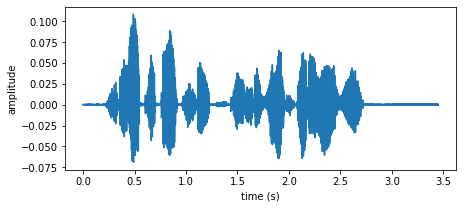

In [54]:
# plot waveform and listen

time_vec = np.arange(T)/fs

plt.figure(figsize=(7,3))
plt.plot(time_vec, s)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

ipd.display(ipd.Audio(s, rate=fs))

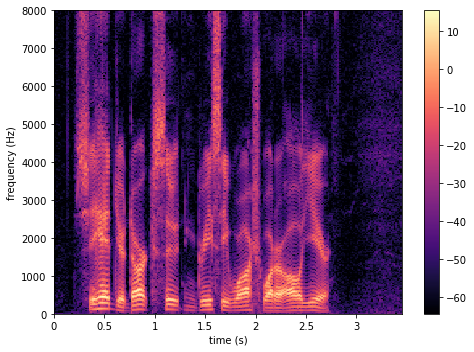

In [55]:
# compute the STFT and plot the power spectrogram

wlen_sec = 32e-3 # STFT window length in seconds
hop_percent = .5 # hop size as a percent of the window length
wlen = int(wlen_sec*fs) # window length in samples
wlen = np.int(np.power(2, np.ceil(np.log2(wlen)))) # next power of 2
F = wlen//2+1 # number of non-redundant frequency bins
hop = np.int(hop_percent*wlen) # hop size in samples
win = np.sin(np.arange(.5,wlen-.5+1)/wlen*np.pi); # sine analysis window

S = librosa.stft(s, n_fft=wlen, hop_length=hop, win_length=wlen, window=win) # STFT of the source signal

plt.figure(figsize=(7,5))
librosa.display.specshow(librosa.power_to_db(np.abs(S)**2), sr=fs, hop_length=hop, x_axis='time', y_axis='hz')

plt.colorbar()

plt.ylabel('frequency (Hz)')
plt.xlabel('time (s)')
plt.tight_layout()

#### 1.2.2 Recording configuration

We define the recording configuration, i.e. the source and microphone cartesian coordinates (in the horizontal plan).

In [56]:
def plot_recording_config(q_m1, q_m2, q_s):
    # A function to plot the recording configuration given the source and microphone coordinates
    
    if len(q_s.shape)>1:
        n_src = q_s.shape[1]
    else:
        n_src = 1         
        q_s = q_s[:,np.newaxis]
    
    plt.plot(q_m1[0], q_m1[1], 'o')
    plt.plot(q_m2[0], q_m2[1], 'o')
    
    legend = ['mic1', 'mic2']
    
    for j in np.arange(n_src):

        plt.plot(q_s[0,j], q_s[1,j], 'x')
        legend.append('source' + str(j+1))
        
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel('x coordinate (m)', fontsize=15)
    plt.ylabel('y coordinate (m)', fontsize=15)
    plt.title('recording configuration', fontsize=15)
    plt.legend(legend, loc='lower right')

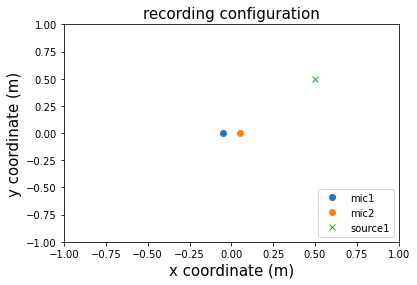

In [57]:
q_m1 = np.array([-5e-2, 0]) # 1st microphone cartesian coordinates
q_m2 = np.array([5e-2, 0]) # 2nd microphone cartesian coordinates
q_s = np.array([0.5, 0.5]) # source cartesian coordinates

plot_recording_config(q_m1, q_m2, q_s)

#### 1.2.3 Spatial cues computation

We compute the ILD and ITD.

In [58]:
d1 = np.linalg.norm(q_m1 - q_s) # source-to-1st microphone distance
d2 = np.linalg.norm(q_m2 - q_s) # source-to-2nd microphone distance

c = 344 # sound velocity in m/s

a = d1/d2 # inter-microphone level ratio
delta_sec = (d2 - d1)/c # time difference of arrival in seconds
delta = delta_sec*fs

print(' inter-microphone level ratio: %.2f' % a)
print(' time difference of arrival: %.2e' % delta_sec)

 inter-microphone level ratio: 1.10
 time difference of arrival: -2.05e-04


#### 1.2.4 Auralization

#### Exercise:

Using the relation (1), complete the following function to compute the microphone signals in the STFT domain, given:
- the source signal, 
- the inter-microphone level ratio, 
- the time difference of arrival (assumed to be much shorter than the STFT analysis window),
- and the STFT parameters.

Then test your auralization function with the above speech signal and recording configuration. Listen to the resulting stereophonic signal **with headphones** and check that you localize the source as expected. 

Change the source position (e.g. make it closer to the left microphone) and verify that it sounds as expected.

In [59]:
def anechoic_FD_auralization(s, a=1, delta=0, wlen=512, hop=256, win='hann'):

    T = s.shape[0] # signal length
    S = librosa.stft(s, n_fft=wlen, hop_length=hop, win_length=wlen, window=win) # STFT of the source signal
    F, N = S.shape
    
    X = np.zeros((F, N, 2), dtype='complex') # STFT of the microphone signals
    
    ########## TODO ###########
    X[:,:,0] = S
    Delta = a*np.exp((-1j*2*np.pi*delta*np.arange(F)/wlen)) 
    X[:,:,1] = S * Delta[:,np.newaxis]
    
#     freq_vec = np.arange(F) # f = [0,...,F-1]
#     H = a*np.exp(-1j*2*np.pi*delta*freq_vec/wlen)
#     X[:,:,0] = S
#     X[:,:,1] = S*H[:,np.newaxis]
    ###########################
    
    x = np.zeros((T,2)) 
    
    # iSTFT to get the time-domain microphone signals
    x[:,0] = librosa.istft(X[:,:,0], hop_length=hop, win_length=wlen, window=win, length=T)
    x[:,1] = librosa.istft(X[:,:,1], hop_length=hop, win_length=wlen, window=win, length=T)

    return x

In [60]:
x = anechoic_FD_auralization(s, a, delta, wlen, hop, win)

ipd.display(ipd.Audio([x[:,0], x[:,1]], rate=fs))

<a id='2'></a>

## 2. Degenerate Unmixing Estimation Technique

### 2.0 Generation of an anechoic mixture of speech signals

Based on what you've done in the previous section, we are now going to generate a stereophonic anechoic mixture of $J=3$ speech source signals, that you will then unmix using DUET algorithm.

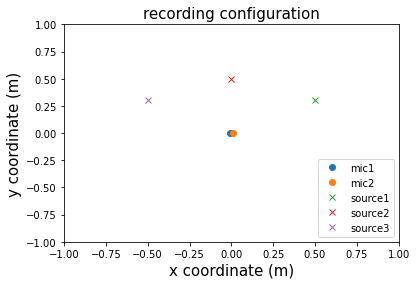

In [61]:
# recording configuration

q_m1 = np.array([-1e-2, 0]) # 1st microphone cartesian coordinates
q_m2 = np.array([1e-2, 0]) # 2nd microphone cartesian coordinates
q_s = np.array([[.5, .3],
               [0, .5],
               [-.5, .3]]).T # source cartesian coordinates, shape (2, 3)

plot_recording_config(q_m1, q_m2, q_s)

In [67]:
# ITD and ILD computation

d1 = np.linalg.norm(q_m1[:,np.newaxis] - q_s, axis=0) # sources-to-1st microphone distance
d2 = np.linalg.norm(q_m2[:,np.newaxis] - q_s, axis=0) # sources-to-2nd microphone distance

a = d1/d2 # inter-microphone level ratio（ITD）
delta_sec = (d2 - d1)/c # time difference of arrival in seconds(ILD)
delta = delta_sec*fs

print('Attenuations: %.2f, %.2f, %.2f' % tuple(a))
print('Delays: %.2f, %.2f, %.2f' % tuple(delta))

Attenuations: 1.03, 1.00, 0.97
Delays: -0.80, 0.00, 0.80


We now create a mixture of speech signals based on the recording configuration previously specified. 

Text(0, 0.5, 'amplitude')

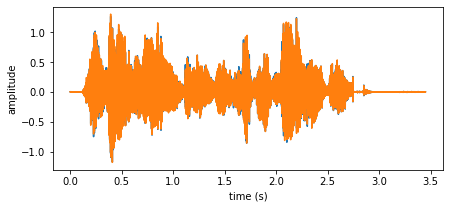

In [63]:
from create_mixture import create_mixture
# The function ```create_mixture``` creates a mixture signal given a list of
# monophonic source signals, the auralization parameters (attenuation and delays) 
# and STFT parameters. It uses the ```anechoic_FD_auralization``` function that you 
# defined previously.

source_wavefiles = ['voice_woman_1.wav', 'voice_man_1.wav','voice_woman_2.wav']
source_wavefiles = [os.path.join(data_path, wavefile) for wavefile in source_wavefiles]

J = len(source_wavefiles)

x = create_mixture(anechoic_FD_auralization, source_wavefiles, a, delta, wlen, hop, win)
T = x.shape[0]

time_vec = np.arange(T)/fs

plt.figure(figsize=(7,3))
plt.plot(time_vec, x)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

Listen to the resulting mixture signal.

In [64]:
ipd.Audio([x[:,0], x[:,1]], rate=fs) 

### 2.1 DUET - Theory

**Acknowledgements**: The following presentation of DUET is largely inspired from [S. Rickard, "The DUET Blind Source Separation
Algorithm", 2007](https://pdfs.semanticscholar.org/1413/746141f2871e0f45056a7696e019b8f8a100.pdf). 

---

Our objective is now to separate the individual speech source signals from their anechoic stereophonic mixture. This is an under-determined (or degenerate) source sepration problem. As we have more sources than microphones, we have to estimate more variables than equations.

We will use DUET, the Degenerate Unmixing Estimation Technique, whose principle can be summarized in one sentence: 

**It is possible to blindly separate an arbitrary number of sources given
just two anechoic mixtures provided the time–frequency representations of the sources do not overlap too much, which is a reasonable assumption for speech signals.**

**Notations**: Let $S_{j}(f,n)$ denote the STFT of the $j$-th source signal, with $j \in \{1, ... J\}$. We first consider a monophonic mixture signal: 
$$X(f,n) = \sum_{j=1}^J S_{j}(f,n).$$

#### 2.1.1 Binary masking and W-disjoint orthogonality

 We assume that the source signals have disjoint time-frequency supports. That is, **at a given time-frequency point $(f,n)$, we cannot have more than one source signal with an STFT coefficient that is is non-zero**. This hypothesis is called "W-disjoint orthogonality" and can be formalized by:

$$S_{j}(f,n)S_{k}(f,n) = 0, \qquad \forall (f,n), \qquad \forall j \neq k.$$ 

This assumption is the mathematical idealization of the condition that it is likely that every time–frequency point in the mixture with significant energy is dominated by the contribution of one source.

W-disjoint orthogonality is crucial to DUET because it allows for the separation of a mixture into its component sources using a **binary mask**:

$$ S_{j}(f,n) = M_{j}(f,n) X(f,n),$$

where the mask is defined by:
 
\begin{equation*}
M_j(f,n) = \begin{cases}
1 & \text{if } S_{j}(f,n) \neq 0 \\
0 & \text{otherwise} \\
\end{cases}.
\end{equation*}
 
But of course, in practice we do not know the mask as we do not have access to the individual source signals. The question is therefore, how do we determine the masks from the observation of the mixture signal? As we are going to see, **DUET exploits the spatial diversity of the anechoic acoustic recording to build the masks**.

#### 2.1.2 Anechoic stereophonic mixture

We consider an anechoic stereophonic mixture **model** defined by:

\begin{equation*}
\begin{bmatrix} X_{1}(f, n) \\ X_{2}(f, n) \end{bmatrix} =
\begin{bmatrix} 1 & ... & 1 \\ a_1 \exp\left({-\imath 2 \pi \frac{f}{L} \delta_1}\right) & ... & a_J \exp\left({-\imath 2 \pi \frac{f}{L} \delta_J}\right) \end{bmatrix}
\begin{bmatrix} S_{1}(f, n) \\ \vdots \\ S_{J}(f, n) \end{bmatrix}. \qquad (2)
\end{equation*}

We further assume that the sources have **different spatial locations**, so that:

$$(a_j \neq a_k) \text{ or } (\delta_j \neq \delta_k) \qquad \forall j \neq k.$$

Indeed, **DUET is based on exploiting the spatial diversity in the mixture to estimate the binary masks for source separation.**

With the further assumption of W-disjoint orthogonality, **at most one source is active at every time-frequency point**, and the mixture model can be rewritten as follows for all $(f,n)$ and for some source index $j$:

\begin{equation*}
\begin{bmatrix} X_{1}(f,n) \\ X_{2}(f,n) \end{bmatrix} =
\begin{bmatrix} 1 \\ a_j  \exp\left({-\imath 2 \pi \frac{f}{L} \delta_j}\right) \end{bmatrix} S_{j}(f, n).
\end{equation*}

#### 2.1.3 DUET algorithm

The main observation that DUET leverages is that **the ratio of the time–frequency representations of the mixtures does not depend on the source components but only on the mixing parameters associated with the active source component**:

$$\frac{X_{2}(f,n)}{X_{1}(f,n)} = a_j\exp\left({-\imath 2 \pi \frac{f}{L}\delta_j}\right), \qquad \forall (f, n) \in \Omega_j = \{(f,n),\, S_{j}(f,n) \neq 0\}.$$

The mixing parameters associated with each time-frequency point can be calculated by:

$$ \hat{a}(f,n) = \left|\frac{X_{2}(f,n)}{X_{1}(f,n)}\right|,$$

$$ \hat{\delta}(f,n) = -\frac{1}{2 \pi f/L}\arg\left(\frac{X_{2}(f,n)}{X_{1}(f,n)}\right), \qquad f > 0.$$

Under the assumption that the microphones are sufficiently close together so that the delay estimate is not incorrect due to phase wrapping, **the local attenuation and delay estimators** $\big(\hat{a}(f,n), \hat{\delta}(f,n)\big)$ **can only take values among the actual mixing parameters** $\{(a_j, \delta_j)\}_{j=1}^J$.

Therefore, we can build a 2D-histogram of the local attenuation and delay estimators to estimate the actual mixing parameters. **We can then associate each time-frequency point of the mixture signal to a given source, in order to perform source separation.**(给定音源位置，分离不同音源)

More precisely, time-frequency masks are built as follows:
$$ M_j(f, n) =  \begin{cases}
1 & \text{if } \big(\hat{a}(f,n), \hat{\delta}(f,n)\big) = (a_j,\delta_j) \\
0 & \text{otherwise} \\
\end{cases}.$$

In practice, because not all of the assumptions are strictly satisfied, the local mixing parameter estimates will not be precisely equal to the mixing parameters, but they will cluster around the true values.

In summary, DUET consists in:

1. Construct the time–frequency representation of both mixtures.

2. Take the ratio of the two mixtures and extract local mixing parameter estimates.

3. Combine the set of local mixing parameter estimates into $J$ pairings corresponding to the true mixing parameter pairings.

4. Generate one binary mask for each determined mixing parameter pair corresponding to the time–frequency points which yield that particular mixing parameter pair.

5. Separate the sources by multiplying each mask with one of the mixtures.

6. Return each demixed time–frequency representation to the time domain.

### 2.2 DUET - Practice

**Acknowledgements**: Some pieces of code are inspired from [The Northwestern University Source Separation Library (nussl)](https://github.com/interactiveaudiolab/nussl).

---

You will now implemement the DUET algorithm. In the following cell, we first remove the leading and trailing silences in the mixture signal, because we can estimate the mixing parameters only for the portions of the mixture that contain speech.

#### 2.2.1 Local mixing parameters computation

In [65]:
x, _ = librosa.effects.trim(x.T, top_db=30) # remove leading and trailing silences in the mixture
x = x.T

**Exercise:**

In the following cell, you have to:

- compute the STFTs $X_1(f,n)$ and $X_2(f,n)$ of the left and right microphone signals, respectively.

- compute the local attenuation coefficients in dB:

    $$\hat{a}_{dB}(f,n) = 20 \log_{10} \hat{a}(f,n),$$

    where 

    $$ \hat{a}(f,n) = \left|\frac{X_{2}(f,n)}{X_{1}(f,n)}\right|.$$

    (You may add a small "epsilon" of $10^{-10}$ in the denominator to avoid division by zero).
    

- compute the local relative delay coefficients (apply the normalization only for $f > 0$):

    $$\hat{\delta}(f,n) = -\frac{1}{2 \pi f/L}\arg\left(\frac{X_{2}(f,n)}{X_{1}(f,n)}\right).$$ 


In [91]:
X_L = librosa.stft(x[:,0], n_fft=wlen, hop_length=hop, win_length=wlen, window=win)
X_R = librosa.stft(x[:,1], n_fft=wlen, hop_length=hop, win_length=wlen, window=win)

F, N = X_L.shape

########## TODO ###########

inter_channel_ratio = (X_R + 1e-10)/(X_L + 1e-10)

attenuation = np.abs(inter_channel_ratio) # relative attenuation between the two channels
attenuation_dB = 20*np.log10(attenuation)

relative_delay[1:,:] = -1/(2*np.pi*np.arange(F)/wlen)[:,np.newaxis][1:,:] * (np.angle(inter_channel_ratio))[1:,:] # relative delay

# inter_channel_ratio = (X_R + 1e-10) / (X_L + 1e-10)

# attenuation = np.abs(inter_channel_ratio) # relative attenuation between the two channels
# attenuation_dB = 20*np.log10(attenuation)

# f_vec = 2 * np.pi * np.arange(F) / wlen
# f_mat = f_vec[:, np.newaxis]

# relative_delay = -np.angle(inter_channel_ratio)
# relative_delay[1:,:] = relative_delay[1:,:] / f_mat[1:,:] # relative delay
##########################

#### 2.2.2 2D histogram computation and peak picking

In the following cell, we plot a 2D histogram of the local mixing parameters $\Big\{ \big(\hat{a}_{dB}(f,n), \hat{\delta}(f,n)\big) \Big\}_{f,n}$ that you extracted. 

**Question**: What do you observe?

<ipython-input-92-f8854b389c22>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(atn_tile, delay_tile, histogram)


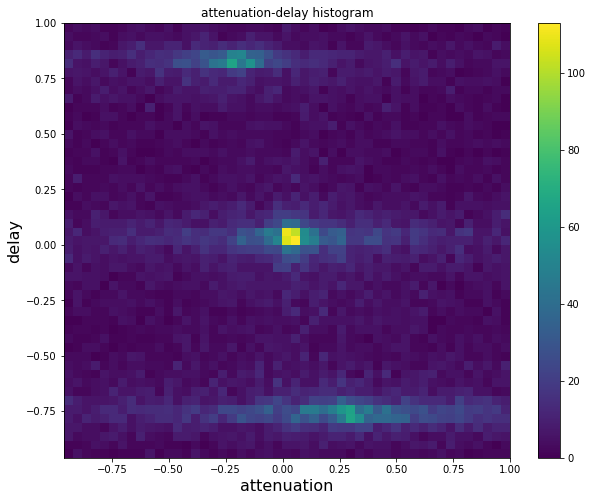

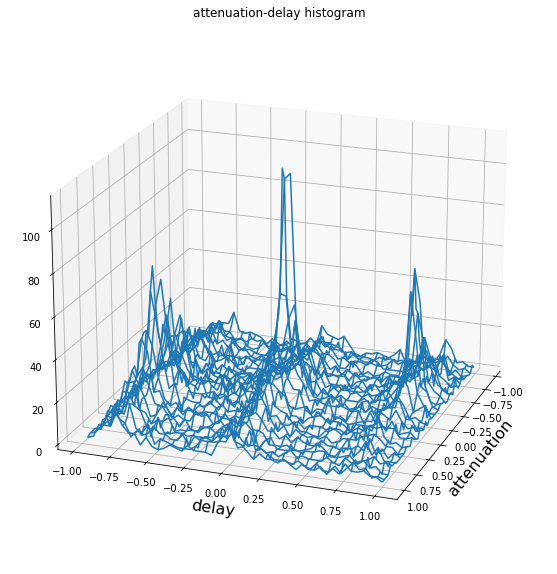

In [92]:
nbins_att = 50 # the number of bins for the attenuation dimension
nbins_delay = 50 # the number of bins for the delay dimension
bins_array = np.array([nbins_att, nbins_delay])

range_array = np.array([[-1, 1], [-1, 1]]) #The leftmost and rightmost edges of the bins along each dimension.
# All values outside of this range will be considered outliers and not counted in the histogram.

# compute the histogram
histogram, atn_bins, delay_bins = np.histogram2d(attenuation_dB.flatten(), relative_delay.flatten(), 
                                                 bins=bins_array, range=range_array)

atn_tile = np.tile(atn_bins[1:], (nbins_att, 1)).T
delay_tile = np.tile(delay_bins[1:].T, (nbins_delay, 1))

fig = plt.figure(figsize=(10,8))
plt.pcolormesh(atn_tile, delay_tile, histogram)
plt.xlabel('attenuation', fontsize=16)
plt.ylabel('delay', fontsize=16)
plt.title('attenuation-delay histogram')
plt.axis('tight')
plt.colorbar()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(atn_tile, delay_tile, histogram, rstride=2, cstride=2)
plt.xlabel('attenuation', fontsize=16)
plt.ylabel('delay', fontsize=16)
plt.title('attenuation-delay histogram')
plt.axis('tight')
ax.view_init(20, 20)

In the following cell, we extract the peaks of the 2D histogram in order to estimate the mixing parameters $\{(\hat{a}_j, \hat{\delta}_j)\}_{j=1}^J$.

In [93]:
from utils import find_peak_indices

peak_indices = find_peak_indices(histogram, J, threshold=0.2, min_dist=[5,5])

atn_indices = [x[0] for x in peak_indices]
delay_indices = [x[1] for x in peak_indices]

atn_peak_dB = atn_bins[atn_indices] # attenuation estimates in dB scale, shape (J,)
atn_peak = 10**(atn_peak_dB/20)  # attenuation estimates in linear scale, shape (J,)

delay_peak = delay_bins[delay_indices] # relative delay estimates, shape (J,)

print('Estimated attenuations: %.2f, %.2f, %.2f' % tuple(atn_peak))
print('Estimated delays: %.2f, %.2f, %.2f' % tuple(delay_peak))

Estimated attenuations: 1.00, 0.97, 1.03
Estimated delays: -0.04, 0.76, -0.84


**Question**: Compare the estimated values with the true ones from the definition of the recording configuration.

#### 2.2.3 Binary masking

Once the peaks have been identified, our goal is to **determine the time–frequency masks which will separate each source from the mixtures**. This is achieved by assigning each time–frequency point $(f,n)$ to the source of index $j \in \{1,...,J\}$ whose peak $(\hat{a}_j, \hat{\delta}_j)$ is closest to the local parameter estimates $\big(\hat{a}(f,n), \hat{\delta}(f,n)\big)$.

More precisely, we build the time-frequency masks as follows:

$$ M_j(f, n) =  \begin{cases}
1 & \text{if } \mathcal{J}(f,n) = j \\
0 & \text{otherwise} \\
\end{cases},$$

where $\mathcal{J}(f,n)$ is defined by

$$ \mathcal{J}(f,n) = \underset{j \in \{1,...,J\}}{\operatorname{argmin}} \left| \hat{a}_j  \exp\left({-\imath 2 \pi \frac{f}{L} \hat{\delta}_j}\right) - \hat{a}(f,n) \exp\left({-\imath 2 \pi \frac{f}{L} \hat{\delta}(f,n)}\right) \right|^2 $$

In the following cell, we compute the masks by applying this procedure. In particular, we use ```np.argmin``` to find the source index that minimizes the above cost.

In [94]:
masks = np.zeros((F, N, J))

f_vec = 2 * np.pi * np.arange(F) / wlen 
f_mat = f_vec[:, np.newaxis]

for f in np.arange(F):
    for n in np.arange(N):
        
        cost = np.abs(atn_peak * np.exp(-1j * f_mat[f] * delay_peak) - 
                      attenuation[f,n] * np.exp(-1j * f_mat[f] * relative_delay[f,n]) )**2
        
        j = np.argmin(cost)
        masks[f,n,j] = 1

<ipython-input-94-c97c745b1f3d>:10: RuntimeWarning: invalid value encountered in multiply
  attenuation[f,n] * np.exp(-1j * f_mat[f] * relative_delay[f,n]) )**2


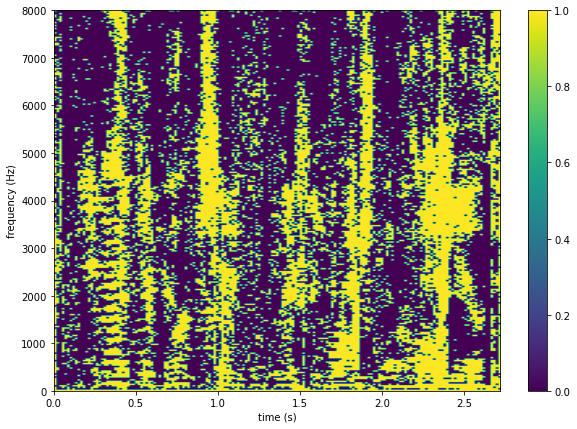

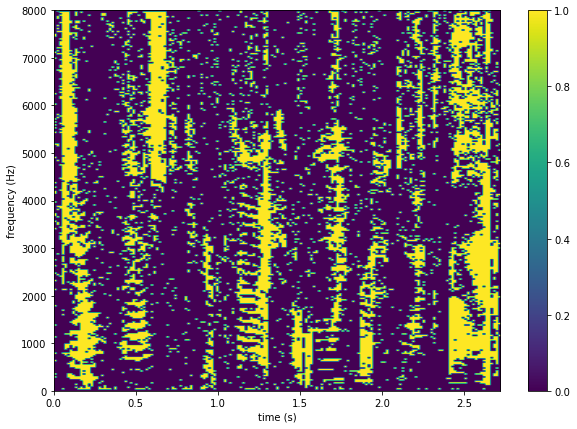

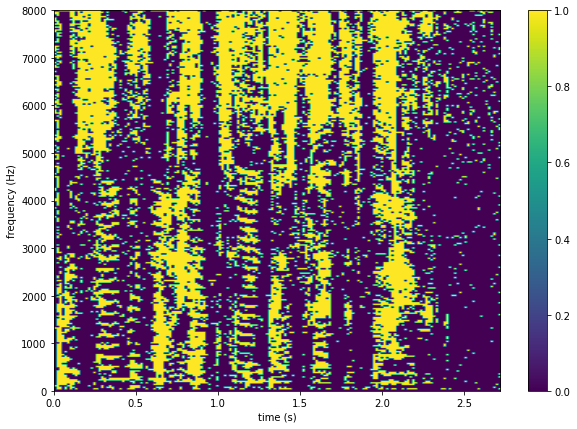

In [95]:
# Plot the masks
for j in np.arange(J):   
    plt.figure(figsize=(10,7))
    plt.imshow(masks[:,:,j], origin='lower', aspect='auto', extent=[0, (N-1)*hop/fs, 0, fs/2])
    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')
    plt.colorbar()

#### 2.2.4 Source separation

**Exercise:** 

Apply the binary masks to the mixture (use the left microphone signal only) in order to compute the STFT of the individual source signals.

In [102]:
S_est = np.zeros((F,N,J), dtype='complex')

########## TODO ###########
for j in np.arange(J):
    S_est[:,:,j] = masks[:,:,j] * X_L
##########################

The separated waveforms are then recovered by inverse STFT.

In [103]:
s_est = np.zeros((T,J))

for j in np.arange(J):
    s_est[:, j] = librosa.istft(S_est[:,:,j], hop_length=hop, win_length=wlen, window=win, length=T)

Listen to the separated sources.

In [104]:
ipd.Audio(s_est[:, 0], rate=fs) 

In [105]:
ipd.Audio(s_est[:, 1], rate=fs) 

In [106]:
ipd.Audio(s_est[:, 2], rate=fs) 